In [44]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Load data

In [45]:
df = pd.read_csv("../data/clean/main_df.csv")

In [46]:
# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})

def process_categorical(df, col):
    """
    Processes a column of *df* as categorical
    """

    def mapping(df, col):

        new_df = df.copy()

        values = new_df[col].unique()
        mapping = {value: i for i, value in enumerate(values)}
        new_df[col] = new_df[col].map(mapping)

        return new_df

    def one_hot(df, col):
        ext_df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        ext_df.drop([col], axis=1, inplace=True)
        
        return ext_df

    return mapping(df, col)

df.fillna(-1, inplace=True)
df = process_categorical(df, "confID")
# df = process_categorical(df, "tmID")
# map_strings_to_int(df, "playerID")
# map_strings_to_int(df, "coachID")
# map_strings_to_int(df, "pos")

df.to_csv("../data/clean/pre.csv", index=False)

# print(df['tmID'].to_frame())

### Turn string values into numerical ones

### Training and evaluation function

In [47]:
from dataclasses import dataclass
from collections import defaultdict

@dataclass
class Result:
    year: int
    accuracy: float
    auc: float

results = defaultdict(list)

def classification(model, df, min_year, max_year, param_list):

    def cv(df, min_year, max_year):
        for i in range(min_year, max_year + 1):
            df_train = df[(df['year'] < i) & (df['year'] > 1)]
            df_test = df[df['year'] == i]

            X_train = df_train.drop("playoff", axis=1)  # Features
            y_train = df_train["playoff"]  # Target variable

            X_test = df_test.drop("playoff", axis=1)  # Features
            y_test = df_test["playoff"]  # Target variable


    def score(model, df, min_year, max_year):
        results = []

        for i in range(min_year, max_year + 1):
            df_train = df[(df['year'] < i) & (df['year'] > 1)]
            df_test = df[df['year'] == i]

            X_train = df_train.drop(["playoff", "year", "tmID"], axis=1)  # Features
            y_train = df_train["playoff"]  # Target variable

            X_test = df_test.drop(["playoff", "year", "tmID"], axis=1)  # Features
            y_test = df_test["playoff"]  # Target variable

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            results.append(accuracy_score(y_test, y_pred))

        return sum(result * (i + 1) for result, i in enumerate(results)) / sum(range(len(results) + 1))

    def param_tuning(model, df, min_year, max_year, param_list):
        grid = HalvingRandomSearchCV(
            model,
            param_distributions=param_list,
            cv=5,
            min_resources='smallest',
            factor=2,
            n_jobs=16,
            random_state=42,
            # scoring=lambda model, X, y: score(model, df, min_year, max_year),
        )
        grid.fit(df.drop(["playoff", "year", "tmID"], axis=1), df["playoff"])

        return grid.best_estimator_

    def test_model(model, df, params):
        pass

    model = param_tuning(model, df, min_year, max_year, param_list)

    for i in range(min_year, max_year + 1):
        df_train = df[(df['year'] < i) & (df['year'] > 1)]
        df_test = df[df['year'] == i]

        df_train.drop(["year", "tmID"], axis=1, inplace=True)
        df_test.drop(["year", "tmID"], axis=1, inplace=True)

        X_train = df_train.drop("playoff", axis=1)  # Features
        y_train = df_train["playoff"]  # Target variable

        X_test = df_test.drop("playoff", axis=1)  # Features
        y_test = df_test["playoff"]  # Target variable

        print(f"\nTrain/Test size for year={i}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        model.fit(X_train, y_train)

        # Predict the response for the test dataset
        y_pred = model.predict(X_test)

        print(f"\nyear = {i}, Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
        print(f"\nyear = {i}, Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        #print(f"\nyear = {i}, AUC: ", roc_auc_score(y_test, y_pred))
        print(f"\nyear = {i}, Accuracy: ", accuracy_score(y_test, y_pred))

        result = Result(
            year=i,
            accuracy=accuracy_score(y_test, y_pred),
            auc=10#roc_auc_score(y_test, y_pred),
        )

        results[model].append(result)

    return model

### Define values for min_year and max_year

In [48]:
min_year = 3
max_year = df['year'].max()

### Decision Tree

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         8
         1.0       1.00      0.25      0.40         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16


year = 3, Confusion Matrix:
 [[8 0]
 [6 2]]

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.40      0.33      0.36         6
         1.0       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, Accuracy:  0.5

Train/Test size f

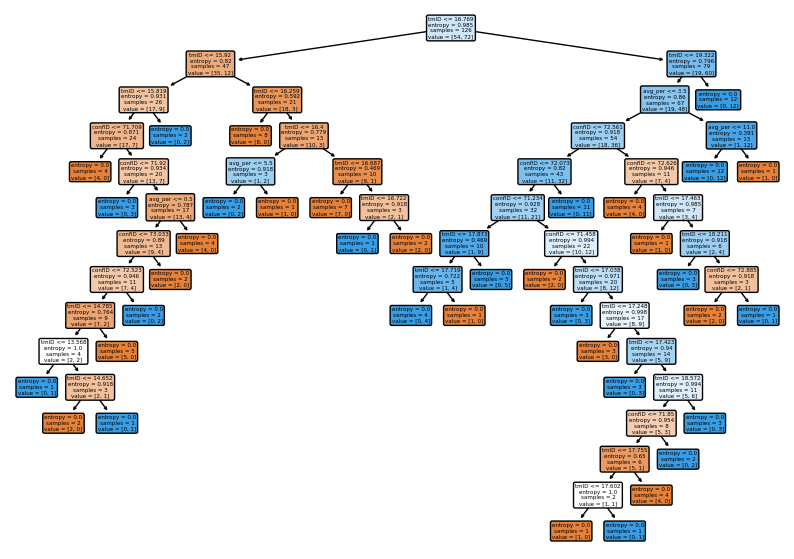

In [49]:
model = DecisionTreeClassifier(random_state=42)
model = classification(model, df, min_year, max_year, param_list={
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 20),
})

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_tree(model, filled=True, feature_names=df.columns.to_list(), rounded=True)
plt.show()

### SVM

In [50]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=42)),
])
classification(model, df, min_year, max_year, param_list={
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__degree': range(1, 10),
    'model__gamma': ['scale', 'auto'],
    'model__C': range(1, 10),
})


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         8
         1.0       0.50      0.50      0.50         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.50        16
weighted avg       0.50      0.50      0.50        16


year = 3, Confusion Matrix:
 [[4 4]
 [4 4]]

year = 3, Accuracy:  0.5

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.40      0.33      0.36         6
         1.0       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, Accuracy:  0.5

Train/Test size for

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVC(C=1, degree=9, gamma='auto', kernel='sigmoid',
                     random_state=42))])

### Logistic Regression

In [51]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42)),
])
classification(model, df, min_year, max_year, param_list={
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__C': range(1, 10),
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'model__max_iter': [1000],
})

/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, s


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.38      0.46         8
         1.0       0.55      0.75      0.63         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16


year = 3, Confusion Matrix:
 [[3 5]
 [2 6]]

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.40      0.33      0.36         6
         1.0       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, Accuracy:  0.5

Train/Test size 

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=8, max_iter=1000, random_state=42,
                                    solver='newton-cg'))])

### Random Forest

In [52]:
model = RandomForestClassifier(random_state=42)
classification(model, df, min_year, max_year, {
    'n_estimators': range(1, 10),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
})


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.50      0.53         8
         1.0       0.56      0.62      0.59         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16


year = 3, Confusion Matrix:
 [[4 4]
 [3 5]]

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.50      0.55         6
         1.0       0.67      0.75      0.71         8

    accuracy                           0.64        14
   macro avg       0.63      0.62      0.63        14
weighted avg       0.64      0.64      0.64        14


year = 4, Confusion Matrix:
 [[3 3]
 [2 6]]

year = 4, Accuracy:  0.6428571428571429

T

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=5,
                       random_state=42)

### Gradient Boosting Classifier

In [53]:
model = GradientBoostingClassifier()
classification(model, df, min_year, max_year, {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': range(1, 10),
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': range(1, 10),
})

/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/naapperas/workspace/uni/4-ano/


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      1.00      0.73         8
         1.0       1.00      0.25      0.40         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16


year = 3, Confusion Matrix:
 [[8 0]
 [6 2]]

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.40      0.33      0.36         6
         1.0       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, Accuracy:  0.5

Train/Test size f

GradientBoostingClassifier(criterion='squared_error', learning_rate=1,
                           max_depth=6, n_estimators=6)

### K Neighbors

In [54]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier()),
])
classification(model, df, min_year, max_year, param_list={
    'model__n_neighbors': range(1, 10),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': range(1, 10),
    'model__p': [1, 2],
})

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.88      0.70         8
         1.0       0.75      0.38      0.50         8

    accuracy                           0.62        16
   macro avg       0.67      0.62      0.60        16
weighted avg       0.67      0.62      0.60        16


year = 3, Confusion Matrix:
 [[7 1]
 [5 3]]

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.40      0.33      0.36         6
         1.0       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, Accuracy:  0.5

Train/Test size f

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='brute', leaf_size=9,
                                      n_neighbors=9))])

### Neural networks

In [55]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=42)),
])
classification(model, df, min_year, max_year, param_list={
    'model__hidden_layer_sizes': [(50, 25)],  
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],  
    'model__solver': ['adam'],
    'model__max_iter': [1000],
    'model__learning_rate': ['constant', 'adaptive', 'invscaling']
})


/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't 


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)


/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.38      0.46         8
         1.0       0.55      0.75      0.63         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16


year = 3, Confusion Matrix:
 [[3 5]
 [2 6]]

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)


/home/naapperas/workspace/uni/4-ano/ac/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to 


year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.40      0.33      0.36         6
         1.0       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, Accuracy:  0.5

Train/Test size for year=5: (46, 4) (13, 4) (46,) (13,)

year = 5, Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.40      0.50         5
         1.0       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13


year = 5, Confusion Matrix:
 [[2 3]
 [1 7]]

year = 5, Accuracy:  0.6923076923076923

Train/Test size for year=6: (59, 4) (13, 4) (59,) (13,)

year

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34


year = 9, Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         6
         1.0       0.60      0.75      0.67         8

    accuracy                           0.57        14
   macro avg       0.55      0.54      0.53        14
weighted avg       0.56      0.57      0.55        14


year = 9, Confusion Matrix:
 [[2 4]
 [2 6]]

year = 9, Accuracy:  0.5714285714285714

Train/Test size for year=10: (113, 4) (13, 4) (113,) (13,)

year = 10, Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.20      0.33         5
         1.0       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13


year = 10, Confusion Matrix:
 [[1 4]
 [0 8]]

year = 10, Accuracy:  0.6923076923076923

Train/Test size for year=11: (126, 4) (1

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34


year = 11, Classification Report:
               precision    recall  f1-score   support

        -1.0       1.00      0.00      0.00      12.0
         0.0       0.00      1.00      0.00       0.0
         1.0       0.00      1.00      0.00       0.0

    accuracy                           1.00      12.0
   macro avg       0.33      0.67      0.00      12.0
weighted avg       1.00      0.00      0.00      12.0


year = 11, Confusion Matrix:
 [[ 0  2 10]
 [ 0  0  0]
 [ 0  0  0]]

year = 11, Accuracy:  0.0


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MLPClassifier(activation='logistic',
                               hidden_layer_sizes=(50, 25),
                               learning_rate='invscaling', max_iter=1000,
                               random_state=42))])

### AdaBoost Classifier

In [56]:
model = AdaBoostClassifier(random_state=42)
classification(model, df, min_year, max_year, param_list={
    'n_estimators': range(1, 10),
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
})



Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.62      0.62         8
         1.0       0.62      0.62      0.62         8

    accuracy                           0.62        16
   macro avg       0.62      0.62      0.62        16
weighted avg       0.62      0.62      0.62        16


year = 3, Confusion Matrix:
 [[5 3]
 [3 5]]

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.83      0.77         6
         1.0       0.86      0.75      0.80         8

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.80      0.79      0.79        14


year = 4, Confusion Matrix:
 [[5 1]
 [2 6]]

year = 4, Accuracy:  0.7857142857142857

Tr

/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_3412473/1587172840.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_34

AdaBoostClassifier(algorithm='SAMME', learning_rate=1, n_estimators=2,
                   random_state=42)

# Results

In [57]:
for model in results:
    for result in results[model]:
        if result.accuracy == 1:
            print(f"\n{model} has 100% accuracy for year {result.year}, possible data leakage")

results_df = pd.DataFrame(
    data=[[
        repr(model), model, result[-1].accuracy, 
        result[-2].accuracy, 
        sum(r.accuracy for r in result[:-1]) / (len(result) - 1),
    ] for model, result in results.items()],
    columns=[
        "repr(model)", "model", "last year accuracy", "second to last year accuracy", "average accuracy",
    ],
)

results_df.sort_values(by=["last year accuracy", "second to last year accuracy", "average accuracy",], ascending=False)


,repr(model),model,last year accuracy,second to last year accuracy,average accuracy
1,"Pipeline(steps=[('scaler', StandardScaler()),\...","(StandardScaler(), SVC(C=1, degree=9, gamma='a...",0.0,0.846154,0.660027
7,"AdaBoostClassifier(algorithm='SAMME', learning...","(DecisionTreeClassifier(max_depth=1, random_st...",0.0,0.769231,0.720982
3,"RandomForestClassifier(criterion='entropy', ma...","(DecisionTreeClassifier(criterion='entropy', m...",0.0,0.769231,0.667153
6,"Pipeline(steps=[('scaler', StandardScaler()),\...","(StandardScaler(), MLPClassifier(activation='l...",0.0,0.692308,0.667153
5,"Pipeline(steps=[('scaler', StandardScaler()),\...","(StandardScaler(), KNeighborsClassifier(algori...",0.0,0.692308,0.665350
2,"Pipeline(steps=[('scaler', StandardScaler()),\...","(StandardScaler(), LogisticRegression(C=8, max...",0.0,0.692308,0.657538
4,GradientBoostingClassifier(criterion='squared_...,"([DecisionTreeRegressor(max_depth=6,\n ...",0.0,0.692308,0.647493
0,"DecisionTreeClassifier(criterion='entropy', ma...","DecisionTreeClassifier(criterion='entropy', ma...",0.0,0.692308,0.637878


## Predictions

### Best average accuracy

In [58]:
best_average_model = max(results, key=lambda model: sum(r.accuracy for r in results[model]))

display(f"Using {best_average_model} for predictions")

last_year = df[df["year"] == df["year"].max()]

X = last_year.drop(["playoff", "year", "tmID"], axis=1)  # Features
y = best_average_model.predict(X)

predictions_df = pd.DataFrame(
    data={
        "tmID": last_year["tmID"],
        "playoff": y,
    }
)

predictions_df


"Using AdaBoostClassifier(algorithm='SAMME', learning_rate=1, n_estimators=2,\n                   random_state=42) for predictions"

,tmID,playoff
2,ATL,0.0
14,CHI,0.0
26,CON,0.0
56,IND,1.0
67,LAS,1.0
81,MIN,1.0
92,NYL,1.0
106,PHO,1.0
127,SAS,1.0
138,SEA,1.0


### Best accuracy

In [59]:
best_model = max(results, key=lambda model: results[model][-2].accuracy)

display(f"Using {best_model} for predictions")

last_year = df[df["year"] == df["year"].max()]

X = last_year.drop(["playoff", "year", "tmID"], axis=1)  # Features
y = best_model.predict(X)

predictions_df = pd.DataFrame(
    data={
        "tmID": last_year["tmID"],
        "playoff": y,
    }
)

predictions_df['playoff'] = predictions_df['playoff'].map({1: 'Y', 0: 'N'})
predictions_df = predictions_df.sort_values('tmID').reset_index(drop=True)

predictions_df

predictions_df.to_csv('./predictions/predictions.csv', index=False)

"Using Pipeline(steps=[('scaler', StandardScaler()),\n                ('model',\n                 SVC(C=1, degree=9, gamma='auto', kernel='sigmoid',\n                     random_state=42))]) for predictions"